In [11]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from io import BytesIO
import random
from zipfile import ZipFile
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.utils import shuffle
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
os.getcwd()

'/workspace'

In [5]:
from zipfile import ZipFile
zf = ZipFile('/workspace/nyu_data.zip', 'r')
zf.extractall('/workspace/')
zf.close()

0.5843137254901961
0.14901960784313725


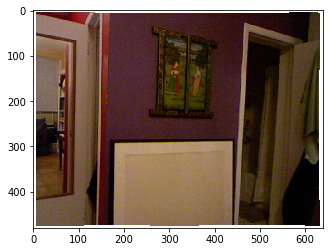

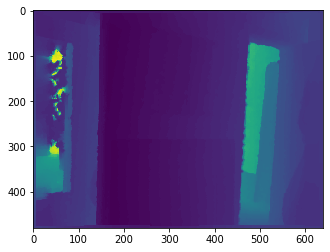

In [3]:
#for testing image
traincsv=pd.read_csv('/workspace/data/nyu2_train.csv')
traincsv = traincsv.rename(columns={'data/nyu2_train/living_room_0038_out/37.jpg': 'image', 'data/nyu2_train/living_room_0038_out/37.png': 'depth'})
traincsv = shuffle(traincsv, random_state=1)
root_dir='/workspace/'
img_name = os.path.join(root_dir,traincsv.iloc[2,0])
image = io.imread(img_name)
depth_name = os.path.join(root_dir,traincsv.iloc[2,1])
depth_image = io.imread((depth_name))
from skimage import img_as_float
depth_float = img_as_float(depth_image)
print(depth_float.max())
print(depth_float.min())

plt.imshow(image)
plt.figure()
plt.imshow(depth_image)

In [12]:
# traincsv = shuffle(traincsv, random_state=0)
traincsv=pd.read_csv('/workspace/data/nyu2_train.csv')
traincsv = traincsv.values.tolist()
traincsv = shuffle(traincsv, random_state=2)

In [5]:
#shuffle the csv file for randomness
#ducpicate

class RandomChannelSwap(object):
    def __init__(self, probability):
        from itertools import permutations
        self.probability = probability
        self.indices = list(permutations(range(3), 3))

    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']
        if not _is_pil_image(image): raise TypeError('img should be PIL Image. Got {}'.format(type(image)))
        if not _is_pil_image(depth): raise TypeError('img should be PIL Image. Got {}'.format(type(depth)))
        if random.random() < self.probability:
            image = np.asarray(image)
            image = Image.fromarray(image[...,list(self.indices[random.randint(0, len(self.indices) - 1)])])
        return {'image': image, 'depth': depth}


In [13]:
#Depth Datasetclass
class DepthDataset(Dataset):
    def __init__(self, traincsv, root_dir, transform=None):

        self.traincsv = traincsv
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.traincsv)

    def __getitem__(self, idx):
        
        sample = self.traincsv[idx]
        img_name = os.path.join(self.root_dir,sample[0])
        image = (Image.open(img_name))
        depth_name = os.path.join(self.root_dir,sample[1])
        depth =(Image.open(depth_name))
#         depth = depth[..., np.newaxis]
        sample1={'image': image, 'depth': depth}

        if self.transform:  sample1 = self.transform({'image': image, 'depth': depth})
        return sample1

0 (640, 480) (640, 480)
1 (640, 480) (640, 480)
2 (640, 480) (640, 480)


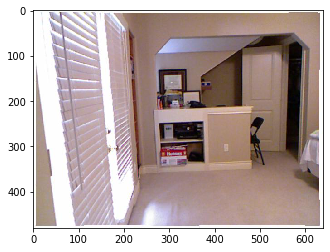

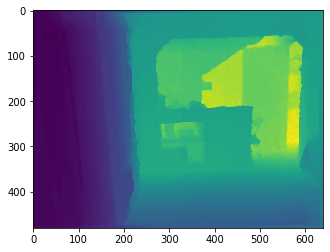

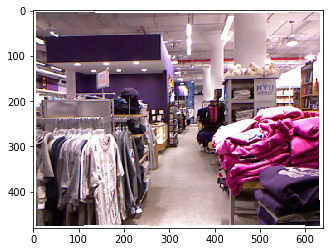

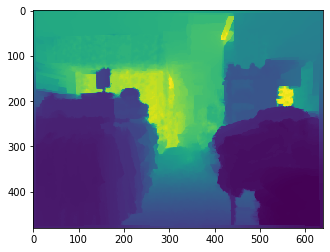

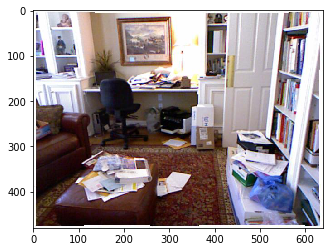

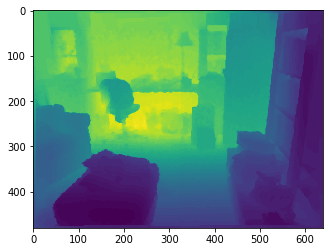

<Figure size 432x288 with 0 Axes>

In [7]:
depth_dataset = DepthDataset(traincsv=traincsv,
                                    root_dir='/workspace/')
fig = plt.figure()
len(depth_dataset)
for i in range(len(depth_dataset)):
    sample = depth_dataset[i]

    print(i, sample['image'].size, sample['depth'].size)


    plt.imshow(sample['image'])
    plt.figure()
    plt.imshow(sample['depth'])
    plt.figure()


    if i == 2:
        plt.show()
        break

In [8]:
def _is_pil_image(img):
    return isinstance(img, Image.Image)

def _is_numpy_image(img):
    return isinstance(img, np.ndarray) and (img.ndim in {2, 3})

# following class flip the both depth and image with probability of 0.5
class Augmentation(object):
    def __init__(self, probability):
        from itertools import permutations
        self.probability = probability
        #generate some output like this [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]
        self.indices = list(permutations(range(3), 3))
        #followed by randomly picking one channel in the list above
    
    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']

        if not _is_pil_image(image):
            raise TypeError(
                'img should be PIL Image. Got {}'.format(type(image)))
        if not _is_pil_image(depth):
            raise TypeError(
                'img should be PIL Image. Got {}'.format(type(depth)))

        if random.random() < 0.5:
            #random number generated is less than 0.5 then flip image and depth
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            depth = depth.transpose(Image.FLIP_LEFT_RIGHT)
            
        if random.random() < self.probability:
            image = np.asarray(image)
            image = Image.fromarray(image[...,list(self.indices[random.randint(0, len(self.indices) - 1)])])    

        return {'image': image, 'depth': depth}

In [10]:
# #following class filp the channes of image with a probability
# class RandomChannelSwap(object):
#     def __init__(self, probability):
#         from itertools import permutations
#         self.probability = probability
#         #generate some output like this [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]
#         self.indices = list(permutations(range(3), 3))
#         #followed by randomly picking one channel in the list above

#     def __call__(self, sample):
#         image, depth = sample['image'], sample['depth']
#         if not _is_pil_image(image): raise TypeError('img should be PIL Image. Got {}'.format(type(image)))
#         if not _is_pil_image(depth): raise TypeError('img should be PIL Image. Got {}'.format(type(depth)))
            
#         if random.random() < self.probability:
#             image = np.asarray(image)
#             image = Image.fromarray(image[...,list(self.indices[random.randint(0, len(self.indices) - 1)])])
            
#         return {'image': image, 'depth': depth}

In [7]:
class ToTensor(object):
    def __init__(self,is_test=False):
        self.is_test = is_test

    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']
        
        #         depth = depth[..., np.newaxis]
#         image=np.array(image)
#         depth=np.array(depth)
        
        
        image = self.to_tensor(image)

        depth = depth.resize((160, 120))

        if self.is_test:
            depth = self.to_tensor(depth).float() / 1000
        else:            
            depth = self.to_tensor(depth).float() * 1000
        
        # put in expected range
        depth = torch.clamp(depth, 10, 1000)

        return {'image': image, 'depth': depth}

    def to_tensor(self, pic):
        pic = np.array(pic)
        if not (_is_numpy_image(pic) or _is_pil_image(pic)):
                raise TypeError(  'pic should be PIL Image or ndarray. Got {}'.format(type(pic)))
                
#         if not(_is_pil_image(pic)): 
#             raise TypeError(
#                 'pic should be PIL Image . Got {}'.format(type(pic)))        
               
        if isinstance(pic, np.ndarray):
            if pic.ndim==2:
                pic=pic[..., np.newaxis]
                
            img = torch.from_numpy(pic.transpose((2, 0, 1)))

            return img.float().div(255)

#         # handle PIL Image
#         if pic.mode == 'I':
#             print(pic.mode)
#             img = torch.from_numpy(np.array(pic, np.int32, copy=False))
#         elif pic.mode == 'I;16':
#             img = torch.from_numpy(np.array(pic, np.int16, copy=False))
#         else:
#             img = torch.ByteTensor(
#                 torch.ByteStorage.from_buffer(pic.tobytes()))
#         # PIL image mode: 1, L, P, I, F, RGB, YCbCr, RGBA, CMYK
#         if pic.mode == 'YCbCr':
#             nchannel = 3
#         elif pic.mode == 'I;16':
#             nchannel = 1
#         else:
#         nchannel = len(pic.mode)
#         img = img.view(pic.size[1], pic.size[0], nchannel)

#         img = img.transpose(0, 1).transpose(0, 2).contiguous()
#         if isinstance(img, torch.ByteTensor):
#             return img.float().div(255)
#         else:
#             return img


In [10]:
depth_dataset = DepthDataset(traincsv=traincsv, root_dir='/workspace/',
                transform=transforms.Compose([Augmentation(0.5),ToTensor()]))
depth_dataset

In [11]:
batch_size=4
train_loader=torch.utils.data.DataLoader(depth_dataset, batch_size, shuffle=True)
train_loader

In [12]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [280]:
images

'image'

In [115]:
Rh=RandomHorizontalFlip()
Rc=RandomChannelSwap(0.5)

fig = plt.figure()
len(depth_dataset)
for i in range(len(depth_dataset)):
    sample = depth_dataset[i]

    
    print(i,sample['image'].size() , sample['depth'].size())

    if i == 0:
        plt.show()
        break

0 torch.Size([3, 480, 640]) torch.Size([1, 240, 320])


<Figure size 432x288 with 0 Axes>

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UpSample(nn.Sequential):
    def __init__(self, skip_input, output_features):
        super(UpSample, self).__init__()        
        self.convA = nn.Conv2d(skip_input, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluA = nn.LeakyReLU(0.2)
        self.convB = nn.Conv2d(output_features, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluB = nn.LeakyReLU(0.2)

    def forward(self, x, concat_with):
        #interpolate x from x.size to larger size(concat_with.shape=(C,H,W))
        up_x = F.interpolate(x, size=[concat_with.size(2), concat_with.size(3)], mode='bilinear', align_corners=True)
        return self.leakyreluB( self.convB( self.leakyreluA(self.convA( torch.cat([up_x, concat_with], dim=1) ) ) )  )

class Decoder(nn.Module):
    def __init__(self, num_features=2208, decoder_width = 0.25):
        super(Decoder, self).__init__()
        features = int(num_features * decoder_width)

        self.conv2 = nn.Conv2d(num_features, features, kernel_size=1, stride=1, padding=1)

        self.up1 = UpSample(skip_input=features//1 + 384, output_features=features//2)
        self.up2 = UpSample(skip_input=features//2 + 192, output_features=features//4)
#         self.up3 = UpSample(skip_input=features//4 +  96, output_features=features//8)
        self.up3 = UpSample(skip_input=features//4 +  96, output_features=features//16)
        self.up4 = UpSample(skip_input=features//8 +  96, output_features=features//16)

        self.conv3 = nn.Conv2d(features//16, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, features):
        x_block0, x_block1, x_block2, x_block3, x_block4 = features[3], features[4], features[6], features[8], features[11]
        x_d0 = self.conv2(x_block4)
        #15x20 to 15x20
        x_d1 = self.up1(x_d0, x_block3)
        #15x20 to 30x40
        x_d2 = self.up2(x_d1, x_block2)
        #30x40 to 60x80
        x_d3 = self.up3(x_d2, x_block1)
        #60x80 to 120x160
#         x_d4 = self.up4(x_d3, x_block0)
        #120x160 to 240x320
        return self.conv3(x_d3)
       # return self.conv3(x_d4)

#Encoder uses the densenet_161 pretrained model
#following encoder encodes the image and store the features output from each output of layer
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()       
        import torchvision.models as models
        self.original_model = models.densenet161( pretrained=True )

    def forward(self, x):
        features = [x]
        for k, v in self.original_model.features._modules.items(): features.append( v(features[-1]) )
        return features

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        return self.decoder( self.encoder(x) )

In [49]:
root_dir='C:/Users/alins/OneDrive/Documents/MENG/Project/Depth Estimation/'
img_name = os.path.join(root_dir,traincsv.iloc[2,0])
image = io.imread(img_name)

features = []
for i,(k, v) in enumerate(original_model.features._modules.items()): 
    print(k,v)


conv0 Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
norm0 BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu0 ReLU(inplace=True)
pool0 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
denseblock1 _DenseBlock(
  (denselayer1): _DenseLayer(
    (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (denselayer2): _DenseLayer(
    (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv1): Conv2d(144, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm2): B

In [58]:
for i,(k, v) in enumerate(original_model.features._modules.items()): 
    print(k,i+1)

conv0 1
norm0 2
relu0 3
pool0 4
denseblock1 5
transition1 6
denseblock2 7
transition2 8
denseblock3 9
transition3 10
denseblock4 11
norm5 12


In [30]:
pip install opencv-python


     |################################| 28.3MB 11.2MB/s eta 0:00:01    |############                    | 10.9MB 9.6MB/s eta 0:00:02
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install kornia

Note: you may need to restart the kernel to use updated packages.


In [17]:
import torch
import cv2
from math import exp
import torch.nn.functional as F
#import pytorch_ssim
import kornia 
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):
    ssim = kornia.losses.SSIM(window_size=11,max_val=val_range,reduction='none')
    return ssim(img1, img2)
    L = val_range

    padd = 0
    (_, channel, height, width) = img1.size()
    if window is None:
        real_size = min(window_size, height, width)
        window = create_window(real_size, channel=channel).to(img1.device)

    mu1 = F.conv2d(img1, window, padding=padd, groups=channel)
    mu2 = F.conv2d(img2, window, padding=padd, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=padd, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=padd, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=padd, groups=channel) - mu1_mu2

    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2

    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2
    cs = torch.mean(v1 / v2)  # contrast sensitivity

    ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)

    if size_average:
        ret = ssim_map.mean()
    else:
        ret = ssim_map.mean(1).mean(1).mean(1)

    if full:
        return ret, cs

    return ret

In [15]:
import matplotlib
import matplotlib.cm
import numpy as np


def DepthNorm(depth, maxDepth=1000.0): 
    return maxDepth / depth

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def colorize(value, vmin=10, vmax=1000, cmap='plasma'):
    value = value.cpu().numpy()[0,:,:]

    # normalize
    vmin = value.min() if vmin is None else vmin
    vmax = value.max() if vmax is None else vmax
    if vmin!=vmax:
        value = (value - vmin) / (vmax - vmin) # vmin..vmax
    else:
        # Avoid 0-division
        value = value*0.
    # squeeze last dim if it exists
    #value = value.squeeze(axis=0)

    cmapper = matplotlib.cm.get_cmap(cmap)
    value = cmapper(value,bytes=True) # (nxmx4)

    img = value[:,:,:3]

    return img.transpose((2,0,1))

In [121]:
def LogProgress(model, writer, test_loader, epoch):
    model.eval()
    sequential = test_loader
    sample_batched = next(iter(sequential))
    image = torch.autograd.Variable(sample_batched['image'].cuda())
    depth = torch.autograd.Variable(sample_batched['depth'].cuda(non_blocking=True))
    if epoch == 0: writer.add_image('Train.1.Image', vutils.make_grid(image.data, nrow=6, normalize=True), epoch)
    if epoch == 0: writer.add_image('Train.2.Depth', colorize(vutils.make_grid(depth.data, nrow=6, normalize=False)), epoch)
    output = DepthNorm( model(image) )
    writer.add_image('Train.3.Ours', colorize(vutils.make_grid(output.data, nrow=6, normalize=False)), epoch)
    writer.add_image('Train.3.Diff', colorize(vutils.make_grid(torch.abs(output-depth).data, nrow=6, normalize=False)), epoch)
    del image
    del depth
    del output
    

In [33]:
import time
import argparse
import datetime

import torch
import torch.nn as nn
import torch.nn.utils as utils
import torchvision.utils as vutils    
from tensorboardX import SummaryWriter

# from data import getTrainingTestingData
# from utils import AverageMeter, DepthNorm, colorize

model = Model().cuda()
#model = Model()
print('Model created.')


epochs=5
lr=0.0001
batch_size=1

depth_dataset = DepthDataset(traincsv=traincsv, root_dir='/workspace/',
                transform=transforms.Compose([Augmentation(0.5),ToTensor()]))
train_loader=DataLoader(depth_dataset, batch_size, shuffle=True)
l1_criterion = nn.L1Loss()

optimizer = torch.optim.Adam( model.parameters(), lr )

# Start training...
for epoch in range(epochs):
    path='/workspace/'+str(epoch)+'.pth'        
    torch.save(model.state_dict(), path)
    batch_time = AverageMeter()
    losses = AverageMeter()
    N = len(train_loader)

    # Switch to train mode
    model.train()

    end = time.time()

    for i, sample_batched in enumerate(train_loader):
        optimizer.zero_grad()

        #Prepare sample and target
        image = torch.autograd.Variable(sample_batched['image'].cuda())
        depth = torch.autograd.Variable(sample_batched['depth'].cuda(non_blocking=True))
#         image = torch.autograd.Variable(sample_batched['image'])
#         depth = torch.autograd.Variable(sample_batched['depth'])

        # Normalize depth
        depth_n = DepthNorm( depth )

        # Predict
        output = model(image)

        # Compute the loss
        l_depth = l1_criterion(output, depth_n)
        l_ssim = torch.clamp((1 - ssim(output, depth_n, val_range = 1000.0 / 10.0)) * 0.5, 0, 1)

        loss = (1.0 * l_ssim.mean().item()) + (0.1 * l_depth)

        # Update step
       
        losses.update(loss.data.item(), image.size(0))
        loss.backward()
        optimizer.step()

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        eta = str(datetime.timedelta(seconds=int(batch_time.val*(N - i))))

        # Log progress
        niter = epoch*N+i
        if i % 5 == 0:
            # Print to console
            print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.sum:.3f})\t'
            'ETA {eta}\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})'
            .format(epoch, i, N, batch_time=batch_time, loss=losses, eta=eta))

            # Log to tensorboard
            #writer.add_scalar('Train/Loss', losses.val, niter)
            
    path='/workspace/'+str(epoch)+'.pth'        
    torch.save(model.state_dict(), path)    
#         if i % 300 == 0:
#             LogProgress(model, writer, test_loader, niter)

#     # Record epoch's intermediate results
#     LogProgress(model, writer, test_loader, niter)
#     writer.add_scalar('Train/Loss.avg', losses.avg, epoch)




Model created.
Epoch: [0][0/50687]	Time 0.379 (0.379)	ETA 5:19:54	Loss 1.1276 (1.1276)
Epoch: [0][5/50687]	Time 0.200 (1.319)	ETA 2:48:31	Loss 0.5200 (0.7461)
Epoch: [0][10/50687]	Time 0.197 (2.294)	ETA 2:46:31	Loss 1.0590 (0.7628)
Epoch: [0][15/50687]	Time 0.198 (3.310)	ETA 2:47:35	Loss 0.7765 (0.7684)
Epoch: [0][20/50687]	Time 0.197 (4.314)	ETA 2:46:16	Loss 0.5637 (0.7471)
Epoch: [0][25/50687]	Time 0.191 (5.275)	ETA 2:40:57	Loss 0.6155 (0.7275)
Epoch: [0][30/50687]	Time 0.193 (6.343)	ETA 2:42:48	Loss 0.5819 (0.7064)
Epoch: [0][35/50687]	Time 0.196 (7.287)	ETA 2:45:42	Loss 0.5879 (0.7003)
Epoch: [0][40/50687]	Time 0.196 (8.262)	ETA 2:45:33	Loss 0.5998 (0.6883)
Epoch: [0][45/50687]	Time 0.187 (9.230)	ETA 2:37:56	Loss 0.8415 (0.6859)
Epoch: [0][50/50687]	Time 0.192 (10.162)	ETA 2:41:45	Loss 0.6902 (0.6838)
Epoch: [0][55/50687]	Time 0.188 (11.184)	ETA 2:38:29	Loss 0.5734 (0.6778)
Epoch: [0][60/50687]	Time 0.199 (12.161)	ETA 2:47:47	Loss 0.6249 (0.6717)
Epoch: [0][65/50687]	Time 0.186 (13

KeyboardInterrupt: 

In [269]:
model = Model().cuda()
model.load_state_dict(torch.load('/workspace/2.pth'))
model.eval()


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 7.79 GiB total capacity; 6.90 GiB already allocated; 2.06 MiB free; 37.86 MiB cached)

In [34]:
batch_size=1

depth_dataset = DepthDataset(traincsv=traincsv, root_dir='/workspace/',
                transform=transforms.Compose([Augmentation(0.5),ToTensor()]))
train_loader=DataLoader(depth_dataset, batch_size, shuffle=True)

for sample_batched1  in (train_loader):
    image1 = torch.autograd.Variable(sample_batched1['image'].cuda())
    
    outtt=model(image1 )
    break

    

In [35]:
x=outtt.detach().cpu().numpy()

In [36]:
x.shape
x=x.reshape(120,160)


In [37]:
x.shape

(120, 160)

In [38]:
torch.cuda.empty_cache()

In [39]:
sample_batched1['image'].detach().cpu().numpy().reshape(3,480,640).transpose(1,2,0).shape

(480, 640, 3)

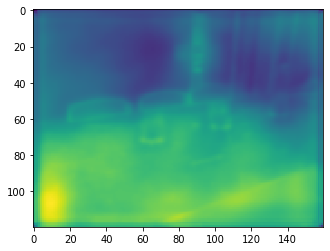

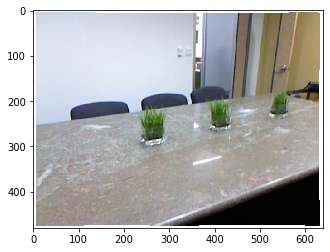

In [40]:
plt.imshow(x)
plt.figure()
plt.imshow(sample_batched1['image'].detach().cpu().numpy().reshape(3,480,640).transpose(1,2,0))